In [15]:
import numpy as np
import os
import pandas as pd
#from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
#import pydot
import matplotlib.pyplot as plt
import datetime
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, accuracy_score, r2_score, mean_squared_error
import geopandas as gpd
import warnings
import shap
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import random
import math
sys.path.append(os.path.abspath("C:/Users/mieke/Documents/Msc Thesis/Notebooks Python/Final/"))
import functions_model #import python file containing the functions

random.seed(1234) # Set random seed

In [ ]:
# For updates
import importlib
importlib.reload(functions_model)

In [14]:
# Importing the data
results_outliers = pd.read_csv(r'D:\other_thesis\rf_outliers.csv')
results_nooutliers = pd.read_csv(r'D:\other_thesis\rf_no.csv')
dataset = gpd.read_file(r'D:\other_thesis\rf_params.geojson') 

In [18]:
data = dataset[dataset['Average Yield(Kg/Ha)'] != 0] # Drop values for which average yield is zero

In [20]:
results_outliers = results_outliers.sort_feature_values('R2', ascending= False)
results_nooutliers = results_nooutliers.sort_feature_values('R2', ascending= False)

In [26]:
features_outliers = list(results_outliers.iloc[0]['Features'])
features_nooutliers = list(results_nooutliers.iloc[0]['Features'])

In [22]:
print('Result model features without outliers:')
print('R_squared:', results_nooutliers.iloc[0]['R2'], '\n', features_nooutliers, '\n')
print('Results model features with outliers:')
print('R_squared:', results_outliers.iloc[0]['R2'], '\n', features_outliers)

Result model features without outliers:
R_squared: 0.2588440178090527 
 ['FAPAR_avg', 'FAPAR_max', 'LAI_avg', 'LAI_max', 'SIF_avg', 'SIF_max', 'SSM_med', 'SSM_max', 'SUSM_med', 'SUSM_max', 'LST_med', 'LST_max', 'LSTN_med', 'LSTN_max', 'Prec_acc', 'Prec_non', 'Irrigated', 'Kharif', 'Soil_I', 'Soil_Vp', 'Soil_WR', 'Soil_Bv', 'Soil_Ne', 'Soil_Vc', 'Soil_Ap', 'Soil_Lc'] 

Results model features with outliers:
R_squared: 0.2988373503741691 
 ['NDVI_avg', 'NDVI_max', 'EVI_avg', 'EVI_max', 'FAPAR_avg', 'FAPAR_max', 'LAI_avg', 'LAI_max', 'SIF_avg', 'SIF_max', 'SSM_med', 'SSM_max', 'SUSM_med', 'SUSM_max', 'LST_med', 'LST_max', 'LSTN_med', 'LSTN_max', 'Prec_acc', 'Prec_non', 'Irrigated']


In [27]:
features_nooutliers = ['FAPAR_avg', 'FAPAR_max', 'LAI_avg', 'LAI_max', 'SIF_avg', 'SIF_max', 'SSM_med', 'SSM_max', 'SUSM_med', 'SUSM_max', 'LST_med', 'LST_max', 'LSTN_med', 'LSTN_max', 'Prec_acc', 'Prec_non', 'Irrigated', 'Kharif', 'Soil_I', 'Soil_Vp', 'Soil_WR', 'Soil_Bv', 'Soil_Ne', 'Soil_Vc', 'Soil_Ap', 'Soil_Lc'] 

features_outliers = ['NDVI_avg', 'NDVI_max', 'EVI_avg', 'EVI_max', 'FAPAR_avg', 'FAPAR_max', 'LAI_avg', 'LAI_max', 'SIF_avg', 'SIF_max', 'SSM_med', 'SSM_max', 'SUSM_med', 'SUSM_max', 'LST_med', 'LST_max', 'LSTN_med', 'LSTN_max', 'Prec_acc', 'Prec_non', 'Irrigated']

START WITH MODEL WITH OUTLIERS

In [23]:
# Recall the selected hyperparameters for the RandomForestRegressor
n_estimator_ = 658
max_depth_ = 28
bootstrap_ = False
max_features_ = 'sqrt'
min_samples_leaf_ = 1
min_samples_split_ = 11
k_fold = 4

In [32]:
array_X = np.array(data[features_outliers])
array_Y = np.array(data['Average Yield(Kg/Ha)'])

cv = functions_model.BlockingTimeSeriesSplit(n_splits = k_fold)

for train_index, test_index in cv.split(array_X):
    MAE_folds = []
    R2_folds = []
    RMSE_folds = []
    accuracy_folds = []
    
    #print('TRAIN:', train_index, 'TEST', test_index) 
    x_train, x_test = array_X[train_index], array_X[test_index]
    y_train, y_test = array_Y[train_index], array_Y[test_index]

    max_features_optimal = int(len(features_outliers)/3)
    if max_features_optimal == 0:
        max_features_optimal = 1

    clf_yield = RandomForestRegressor(n_estimators=n_estimator_, max_depth=max_depth_, bootstrap = bootstrap_, max_features = max_features_, min_samples_leaf = min_samples_leaf_, min_samples_split = min_samples_split_, criterion='mse')

    #Fit to the training data
    clf_yield.fit(x_train, y_train)

    #Make a prediction on the test data
    y_pred = clf_yield.predict(x_test)

    #Calculate mean absolute error
    MAE_folds.append(mean_absolute_error(y_test, y_pred))

    #MAPE
    errors = abs(y_pred - y_test)
    mape = 100 * (errors / y_test)

    # Calculate and display accuracy
    accuracy_folds.append(100 - np.mean(mape))

    #RMSE
    MSE_folds = np.square(np.subtract(y_test, y_pred)).mean() 
    RMSE_folds.append(math.sqrt(MSE_folds))

    #R2
    R2_folds.append(r2_score(y_test, y_pred))
MAE = sum(MAE_folds)/len(MAE_folds)
RMSE = sum(RMSE_folds)/len(RMSE_folds)
R2 = sum(R2_folds)/len(R2_folds)
Accuracy = sum(accuracy_folds)/len(accuracy_folds)

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.


In [33]:
print('MAE: ' + str(MAE))
print('RMSE: ' + str(RMSE))
print('R2: ' + str(R2))
print('Accuracy: ' + str(Accuracy))

MAE: 979.9325624987699
RMSE: 1294.2911453452643
R2: 0.29819336504414384
Accuracy: 38.468495278455734


In [35]:
importances_list = list(clf_yield.feature_importances_)
feature_importances = [(feature, round(importance, 15)) for feature, importance in zip(features_outliers, importances_list)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
feature_importances # 

[('Irrigated', 0.105700104250079),
 ('Prec_acc', 0.068913405728388),
 ('SUSM_max', 0.066472701538988),
 ('SUSM_med', 0.058401080403983),
 ('SSM_med', 0.056975553153536),
 ('Prec_non', 0.056030006366469),
 ('SSM_max', 0.054832984299424),
 ('LSTN_med', 0.050368109622508),
 ('LSTN_max', 0.04957991896462),
 ('LST_max', 0.04734556538958),
 ('FAPAR_avg', 0.045776577757768),
 ('EVI_avg', 0.045253625152233),
 ('NDVI_avg', 0.040754298181356),
 ('SIF_max', 0.039524348013662),
 ('LAI_avg', 0.038785272181125),
 ('SIF_avg', 0.037732712364655),
 ('EVI_max', 0.030220939655824),
 ('NDVI_max', 0.029409082276448),
 ('LST_med', 0.029390918463593),
 ('FAPAR_max', 0.025093412284301),
 ('LAI_max', 0.023439383951458)]

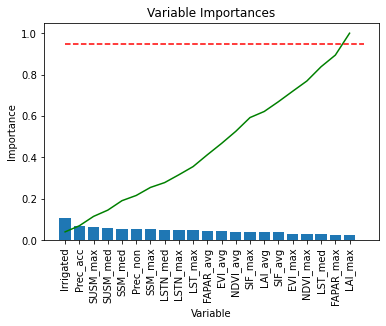

In [39]:
feature_names=[]
feature_values=[]
for i in range(0, len(importances_list)):
    feature_names.append(feature_importances[i][0])
    feature_values.append(feature_importances[i][1])


plt.bar(feature_names, feature_values)
# Cumulative importances
cumulative_importances = np.cumsum(importances_list)
# Make a line graph
plt.plot(feature_names, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(importances_list), color = 'r', linestyles = 'dashed')
plt.xticks(feature_names, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')
plt.show()

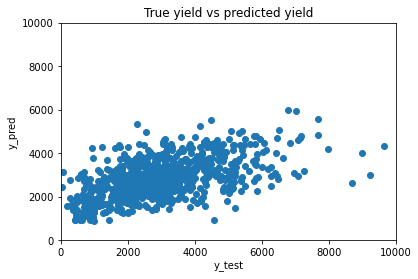

In [41]:
plt.scatter(y_test, y_pred)
plt.title('True yield vs predicted yield')
plt.xlim(0,10000)
plt.ylim(0,10000)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

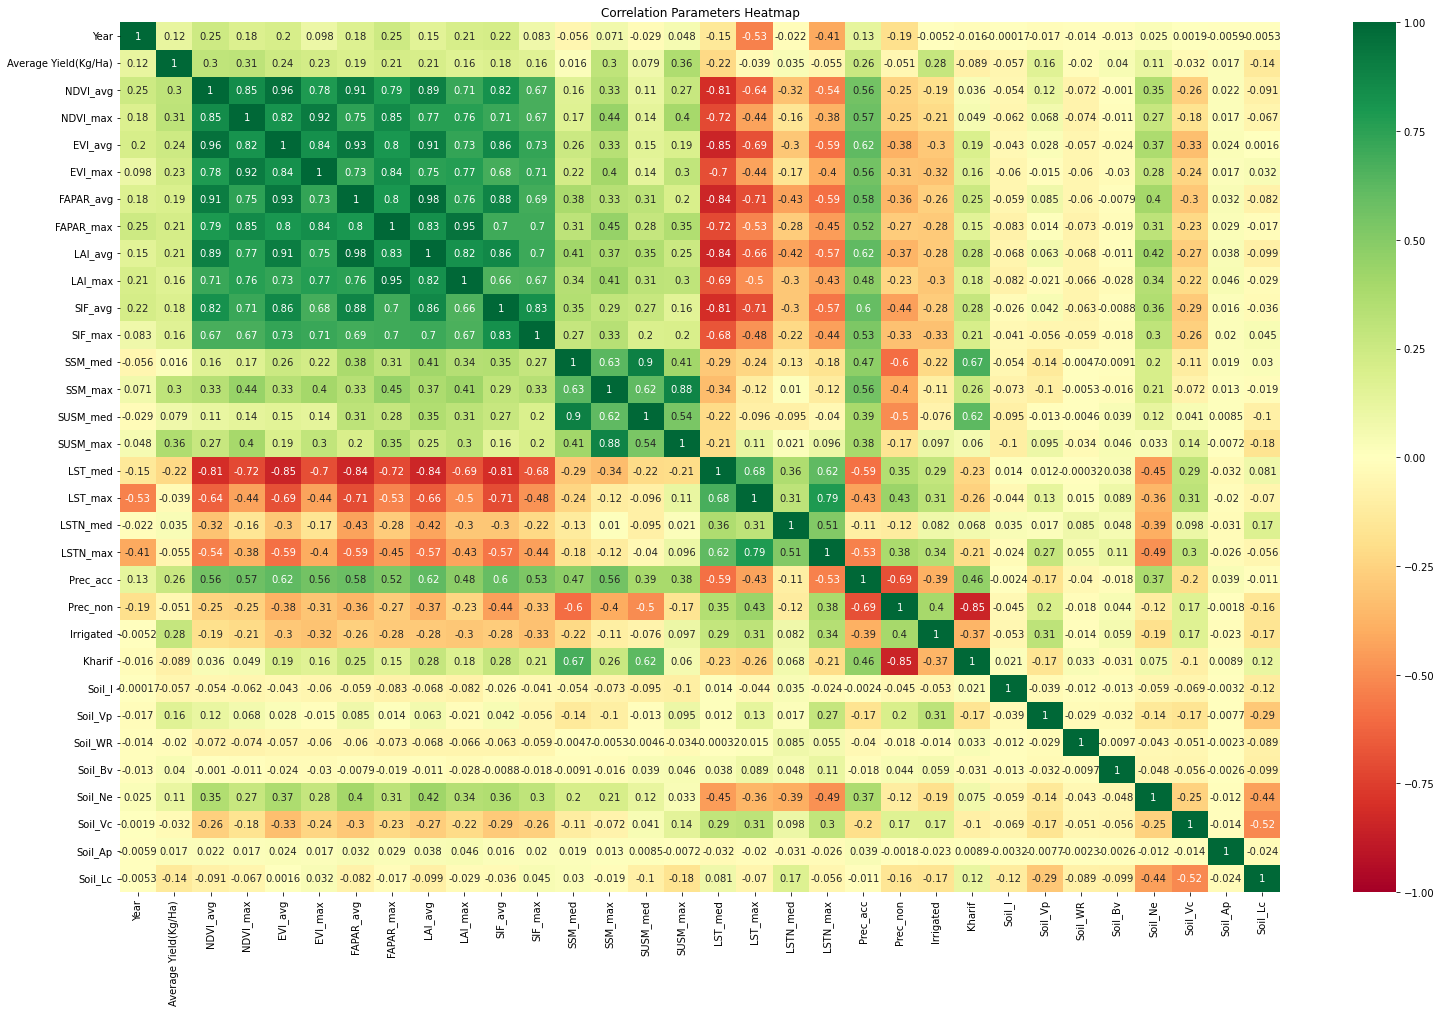

In [44]:

#dataset.columns
data_corr = dataset.iloc[:,[0,3,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37]]
plt.figure(figsize=(26,16))
heatmap = sns.heatmap(data_corr.corr(), vmin=-1, vmax=1, annot=True, cmap = 'RdYlGn')
heatmap.set_title('Correlation Parameters Heatmap')
plt.show()